# Usage Overview

All toolbox algorithms operate on 2d pandas dataframes with rows as unique _users_ and columns as unique _items_. To illustrate basic model fitting and how we handle dense and sparse data differently, we'll use a small simple toy dataset for illustrative purposes.

In [1]:
import numpy as np
import pandas as pd
from emotioncf import NNMF_sgd, create_user_item_matrix, estimate_performance

In [2]:
np.random.seed(0)
ratings_dict = {
    "User": [
        "A","A","A","A","A","B","B","B","B","B","C","C","C","C","C",
        "D","D","D","D","D","E","E","E","E","E","F","F","F","F","F"
    ],
    "Item": [1,2,3,4,5]*6,
    "Rating": np.random.randint(1, 101, size=30)
}
df = pd.DataFrame(ratings_dict)
mat = create_user_item_matrix(df)

# Fitting a model to _dense_ data

Here we have a user x item matrix of ratings. Each of **6 users** rated **5 items** on scale from 1-100. This is a _dense_ dataset because every user rated every item, i.e. no values are missing.

In [3]:
mat

Item,1,2,3,4,5
User,,,,,
A,45,48,65,68,68
B,10,84,22,37,88
C,71,89,89,13,59
D,66,40,88,47,89
E,82,38,26,78,73
F,10,21,81,70,80


We can test how well collaborative filtering would work to recover data _if they were missing_ using the  `NNMF` algorithm trained via stochastic gradient descent. To do so, we can initialize a model and tell it to "sparsify" our data by masking out 25% of the values and retaining 75%. 

In [23]:
model = NNMF_sgd(mat, n_mask_items=.25, random_state=0)

We can see that this approximates a dataset in which each user only provided a rating for 4 of the 5 items. We're now going to fit a model to try to recover what these missing ratings *would have been*.

In [24]:
model.masked_data

Item,1,2,3,4,5
User,,,,,
A,45.0,48,65.0,68.0,NaN
B,10.0,84,22.0,NaN,88.0
C,71.0,89,NaN,13.0,59.0
D,66.0,40,88.0,NaN,89.0
E,NaN,38,26.0,78.0,73.0
F,10.0,21,NaN,70.0,80.0


In [25]:
model.fit()

## Examining model predictions

Lets take a look the predicted ratings matrix. The model makes predictions for *every* user/item using _observed_ values. This enables the recovery of our _missing_ values.

In [26]:
model.predictions

Item,1,2,3,4,5
User,,,,,
A,47.455101,48.105183,63.432343,67.962732,83.855940
B,12.603164,84.060939,22.116645,64.121674,88.015465
C,70.967138,88.974861,26.651709,21.775329,59.147026
D,64.724749,42.070695,88.795312,69.658166,89.013770
E,26.749797,37.901443,29.258709,78.034234,73.080366
F,12.030591,21.000420,19.065140,69.993217,80.050540


We can calculate how well our model did using the `.score()` method. By default this calculates the root mean squared error (RMSE) of our predictions vs the  _true missing_ values, i.e. the 25% we masked out. Unlike other packages, we offer two ways of scoring predictions:

1. _user_ model fit: this is the performance calculated _separately_ per user and then averaged. This approach is more common for calculating metrics in psychological and social science research. This is the default mode of scoring for `.score` so we need to call `.mean` on the result to average across user performance.
2. _all_ model fit: this is the performance ignoring the fact that scores from the same user might be more similar. This is more commonly used in machine-learning or industry settings and returns a single scalar value. We can set `by_user=False` to obtain this mode of scoring.

RMSE is interpretable as the average amount of error on the *original scale* of the data (1-100). We can see that the model easily learns to re-create the original (`observed`) ratings nearly perfectly, but its performance is lower on the unobserved ratings (`missing`).

In [27]:
print(f"RMSE observed: {model.score(dataset='observed', by_user=False)}")
print(f"RMSE missing: {model.score(dataset='missing')}")

RMSE observed: 2.1759141262248343
RMSE missing: User
A    15.855940
B    27.121674
C    62.348291
D    22.658166
E    55.250203
F    61.934860
Name: rmse_missing, dtype: float64


## Evaluting Model Fit

RMSE isn't the only performance metric we currently support. We can also calculate:

- mean-absolute-error (MAE)
- mean-squared-error (MSE)
- pearson correlation
Rather writing custom code to repeatedly call `.score()` for each metric and group, we provide a convenient `.summary()` method which will calculate all of these!

In [28]:
model.summary()

,algorithm,dataset,group,metric,score
0,NNMF_sgd,missing,all,correlation,-0.720794
1,NNMF_sgd,missing,all,mae,40.861522
2,NNMF_sgd,missing,all,mse,2046.034948
3,NNMF_sgd,missing,all,rmse,45.233118
4,NNMF_sgd,missing,user,correlation,NaN
5,NNMF_sgd,missing,user,mae,40.861522
6,NNMF_sgd,missing,user,mse,2046.034948
7,NNMF_sgd,missing,user,rmse,40.861522
8,NNMF_sgd,observed,all,correlation,0.997934
9,NNMF_sgd,observed,all,mae,1.069042


We also provide a `.plot_predictions` method for visualizing both performance and predicted ratings:

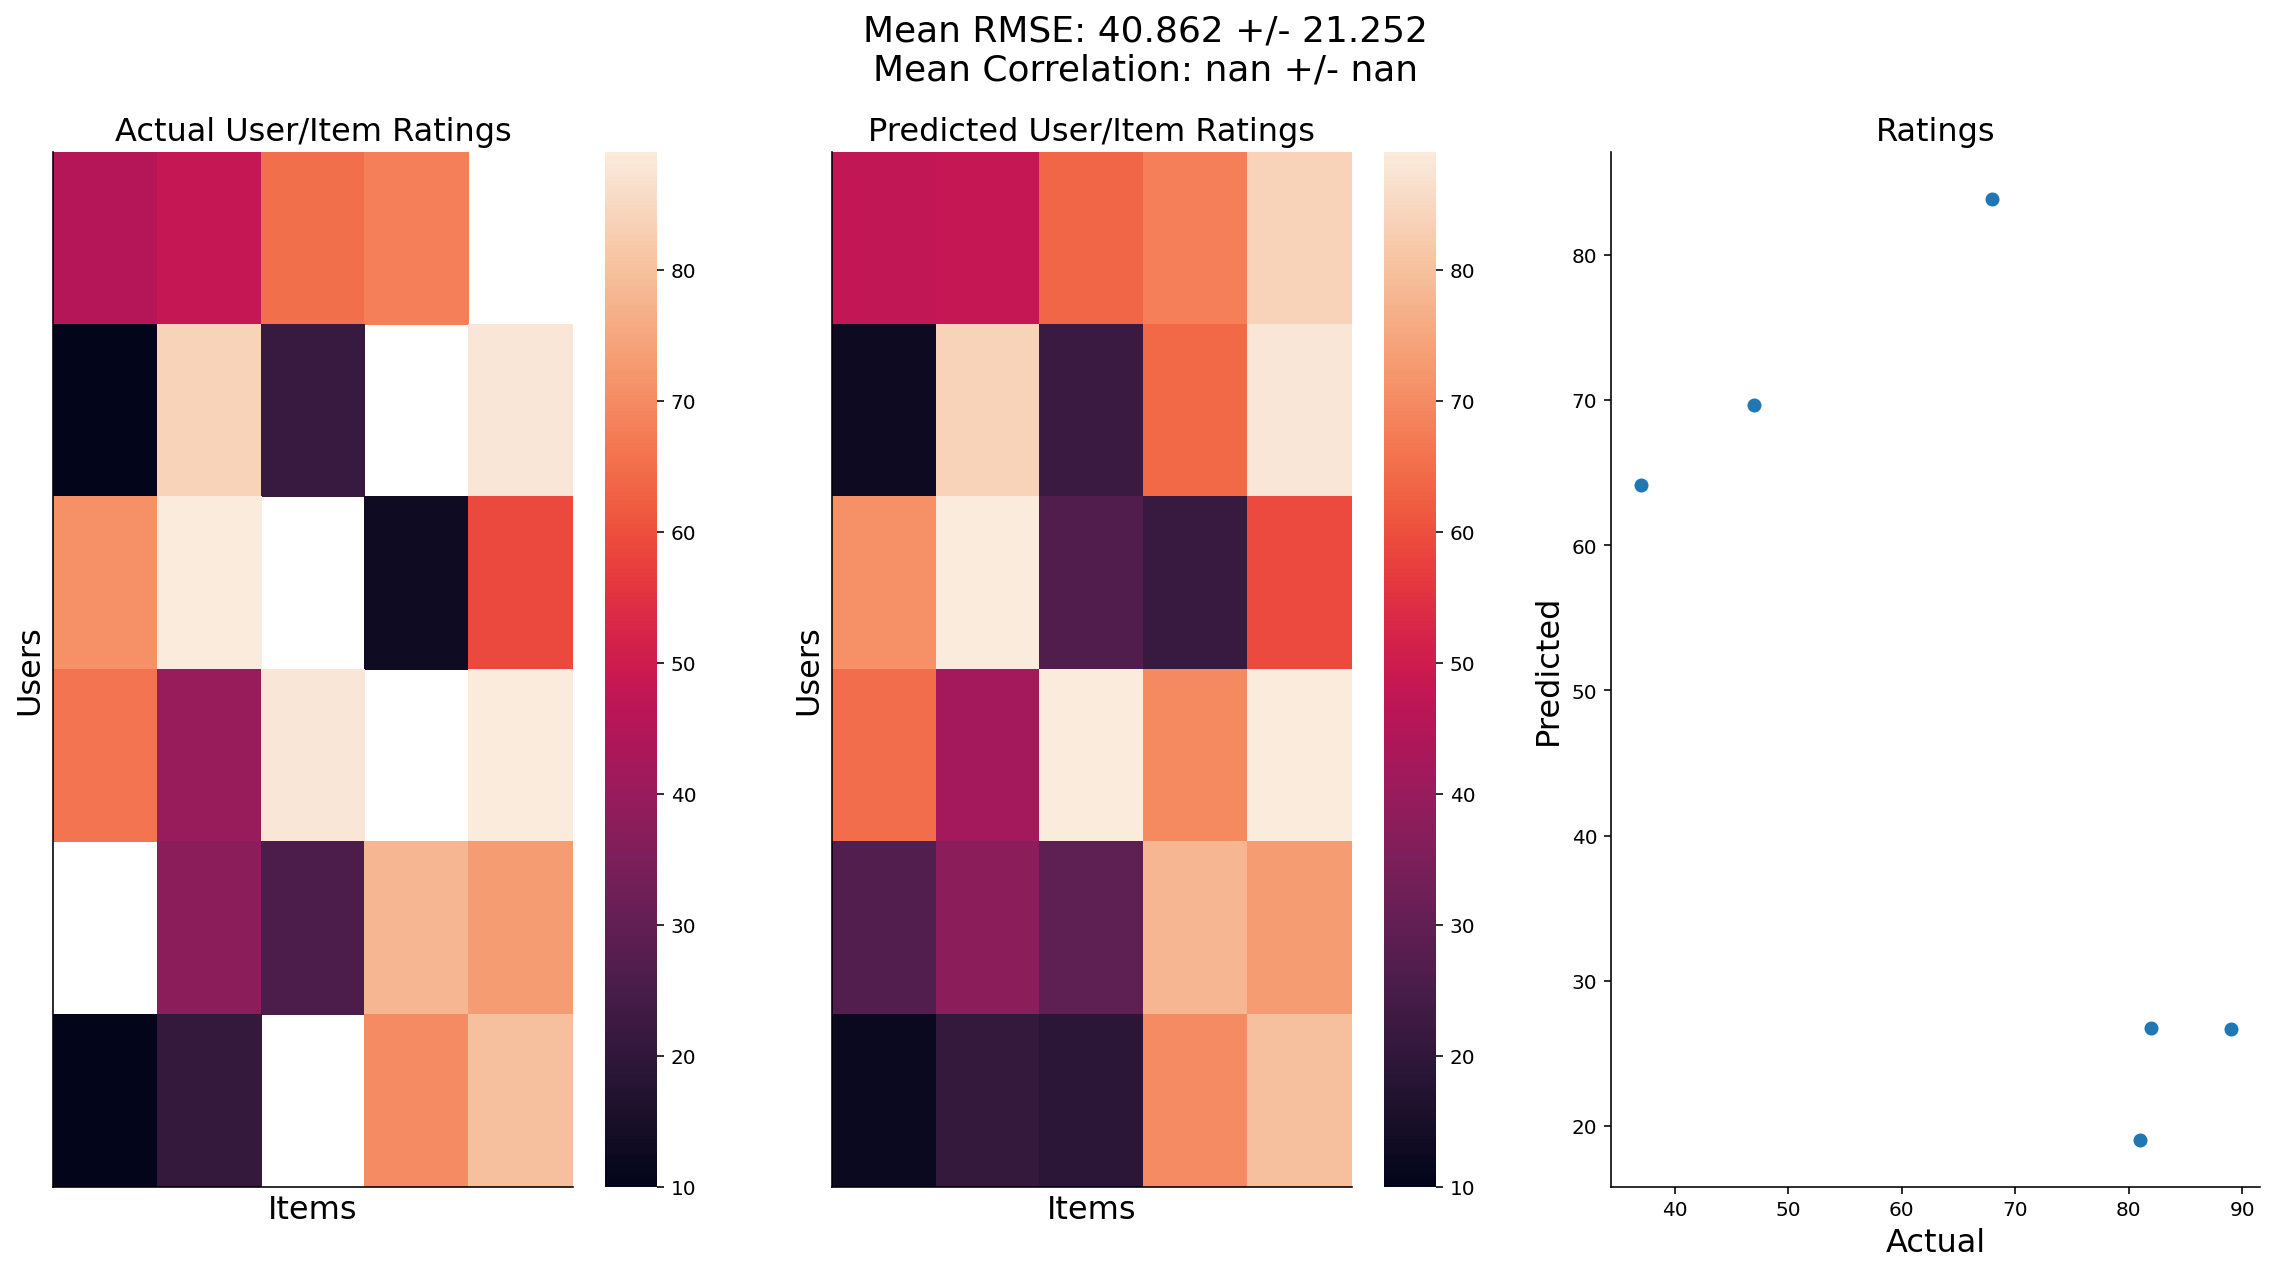

In [29]:
model.plot_predictions();

## Benchmarking Model Performance

For benchmarking a model's performance given dense data, it's helpful to repeat the process above (masking, fitting, scoring) multiple times with different random masks. We can then compute the _average_ performance across these multiple runs to ensure that a model's performance isn't a fluke due to a particular combination of masked and unmasked data. 

For convenience we offer an `esimate_performance` function that does just that! Let's run it for 10 iterations with the same level of masking (75%)

In [10]:
all_results = estimate_performance(
    NNMF_sgd, mat, n_iter=10, n_mask_items=.75
)

Data sparsity is 0.0%. Using random masking...


We can see now that the performance we observed above on `missing` data was a "lucky" overestimate. After rerunning the estimation with different random masks, the mean performance drops substantially and there's quite a bit of variance. This is because our dataset is a small toy example.

In [11]:
all_results

,algorithm,dataset,group,metric,mean,std
0,NNMF_sgd,missing,all,correlation,0.020123,0.222994
1,NNMF_sgd,missing,all,mae,25.765061,3.621663
2,NNMF_sgd,missing,all,mse,901.831463,200.084612
3,NNMF_sgd,missing,all,rmse,29.865007,3.318769
4,NNMF_sgd,missing,user,correlation,0.090882,0.156474
5,NNMF_sgd,missing,user,mae,25.765061,3.621663
6,NNMF_sgd,missing,user,mse,901.831463,200.084612
7,NNMF_sgd,missing,user,rmse,28.831973,3.523668


By default `estimate_performance` only returns performance `missing` data. To see performance on all subsets use `return_full_performance = True`. You can also use `return_agg=False` if you want to see performance for each iteration separately.

In [12]:
estimate_performance(
    NNMF_sgd, mat, n_iter=10, n_mask_items=0.75, return_full_performance=True
)

Data sparsity is 0.0%. Using random masking...


,algorithm,dataset,group,metric,mean,std
0,NNMF_sgd,missing,all,correlation,0.016681,0.182794
1,NNMF_sgd,missing,all,mae,24.209396,2.128677
2,NNMF_sgd,missing,all,mse,815.364682,107.265136
3,NNMF_sgd,missing,all,rmse,28.500079,1.858964
4,NNMF_sgd,missing,user,correlation,0.164990,0.244858
5,NNMF_sgd,missing,user,mae,24.209396,2.128677
6,NNMF_sgd,missing,user,mse,815.364682,107.265136
7,NNMF_sgd,missing,user,rmse,27.129655,2.036189
8,NNMF_sgd,observed,all,correlation,0.999998,0.000004
9,NNMF_sgd,observed,all,mae,0.007674,0.009798


# Fitting a model to _sparse_ data

While manually "sparsifying" a dense dataset is useful for benchmarking, in many scenarios data will _already_ be sparse and we won't have ground truth values to compare against. Of course models support this use case as well. This time when we intialize a model we don't pass in any thing for `n_mask_items`. Models are smart enough to raise an error if provided a sparse dataset and additional masking is requested.

In [13]:
# Lets use our masked data from before as if it were a real dataset
real_sparse_mat = model.masked_data

new_model = NNMF_sgd(real_sparse_mat)

data contains NaNs...treating as pre-masked


Now we can proceed to fitting just like before, but there's a catch:

this time we won't be able to obtain a score for the _missing_ data because we never observed it in the first place!

In [14]:
new_model.fit()
print(f"RMSE observed: {new_model.score(dataset='observed')}")
print(f"RMSE all: {new_model.score(dataset='full')}")

RMSE observed: 0.010886168660715421
RMSE all: 0.010886168660715421


In [15]:
print(f"RMSE missing: {new_model.score(dataset='missing')}")

RMSE missing: None


/Users/Esh/Documents/pypackages/emotioncf/emotioncf/base.py:135: UserWarning: Cannot score predictions on missing data because true values were never observed!
  warnings.warn(


## Benchmarking Model Performance

One popular approach to handle this scenario is to use _cross-validation_, whereby a model is estimated on a subset of the data (_train_ set) and evaluated on an independent subset (_test_ set). In a collaborative filtering context, standard methods to generate cross-validation folds, such as those provided by `sklearn` will not work. This is because we don't want to train on a subset of _users_ or a subset of _items_ (observations and features respectively in a typical supervised-learning situation). Instead, we want to predict new _combinations_ of users + items that we did not observe.

To do this we can add _additional sparsity_ in a way keeps track of which user-item values we mask out in the training set to ensure that these values are "un-masked" in the testing set. By doing this we, can evaluate the performance of a model despite having sparse (missing) data to begin with!

Using this approach we actually have 2 different kinds of sparsity: 

1. A value that was *never* observed and therefore doesn't exist at all in either train or test splits. By definition, there's no way for us to incorporate this into model evaluation. 
2. A value we _manually mask out_ when fitting the model (train set) and _unmask_ when we want to evaluate the model (test set). These observations will serve as the model's _generalization_ performance. 

Conveniently, `estimate_performance` is smart enough to realize your input dataset is sparse and will automatically switch to cross-validation. You can control the number of folds using the `n_folds` argument. All other arguments that only apply to dense data (e.g. `n_mask_item`) will be ignored.

**Note**: keep in mind that using this approach will _increase_ the sparsity of an already sparse dataset!

You can control the extent to which this happens using the `n_folds` parameter. More folds, means that the model is trained on _more_ data thereby decreasing the additional sparsity.

Here we run this using 10 folds which means that ~90% of the _observed_ values will be used for training the model and ~10% of the _observed_ values will be used for testing performance.

In [16]:
real_sparse_mat

Item,1,2,3,4,5
User,,,,,
A,45.0,48.0,NaN,68,68.0
B,10.0,NaN,22.0,37,88.0
C,NaN,89.0,89.0,13,59.0
D,66.0,NaN,88.0,47,89.0
E,82.0,38.0,NaN,78,73.0
F,10.0,21.0,81.0,70,NaN


In [17]:
cv_results = estimate_performance(NNMF_sgd, real_sparse_mat, n_folds=10)

Data sparsity is 20.0%. Using cross-validation...


In this particular example, the performance of our model on unseen data drops even further because of how small our dataset was to begin with.

In [18]:
cv_results

,algorithm,dataset,group,metric,mean,std
0,NNMF_sgd,test,all,correlation,-0.758746,0.626376
1,NNMF_sgd,test,all,mae,36.619235,10.661269
2,NNMF_sgd,test,all,mse,1881.355182,823.004537
3,NNMF_sgd,test,all,rmse,42.014292,11.360480
4,NNMF_sgd,test,user,correlation,-1.000000,0.000000
5,NNMF_sgd,test,user,mae,35.503419,10.715971
6,NNMF_sgd,test,user,mse,1796.397237,840.016277
7,NNMF_sgd,test,user,rmse,35.842384,10.531357


Like before we can use `return_full_performance = True` and/or `return_agg=False` to see performance for all data subsets (i.e. test _and_ train) and separately per fold

In [19]:
 estimate_performance(NNMF_sgd, real_sparse_mat, n_folds=10, return_agg=False, return_full_performance=True)

Data sparsity is 20.0%. Using cross-validation...


,algorithm,dataset,cv_fold,group,metric,score
0,NNMF_sgd,test,1,all,correlation,NaN
1,NNMF_sgd,test,2,all,correlation,-1.000000
2,NNMF_sgd,test,3,all,correlation,-0.955540
3,NNMF_sgd,test,4,all,correlation,0.292516
4,NNMF_sgd,test,5,all,correlation,-0.624561
...,...,...,...,...,...,...
155,NNMF_sgd,train,6,user,rmse,0.007064
156,NNMF_sgd,train,7,user,rmse,0.016320
157,NNMF_sgd,train,8,user,rmse,0.003909
158,NNMF_sgd,train,9,user,rmse,0.005436


# Concluding Thoughts

This notebook has provided a full example of how to fit a model in several different ways. Here are a few parting tips to help you plan your own analyses:

If you already have a _sparse_ dataset, use `estimate_performance` along with `n_folds` to help you assess how well collborative filtering works for your use case (at the cost of increasing sparsity during evaluation). This approach is the defacto standard in several other collaborative filtering toolboxes such as [Surprise](http://surpriselib.com/). 

If you're working with a small but _dense_ dataset, using `estimate_performance` with `n_iter` and `n_mask_items` provides you more fine grain control over exploring how different levels of sparsity affect performance This is useful when making new data collection or experimental design choices as it simulates how well a model will perform had your dataset been _sparse_.
